# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA   
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline
warnings.filterwarnings("ignore")
'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter = ";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter = ";")

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
#azdias.info()
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.info()
feat_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.
for attribute in feat_info['attribute']:

    temp = feat_info[feat_info['attribute']==attribute].missing_or_unknown.iloc[0].strip('[]').split(',')
    
    nan_list = [float(x) if x.lstrip('-').isnumeric() else x for x in temp]
    #lstrip for getting rid of the negative sign in the string
    #isnumeric checks whether it is number or not
    

    azdias[attribute].replace(to_replace=nan_list,
                      value=np.nan, inplace=True)
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

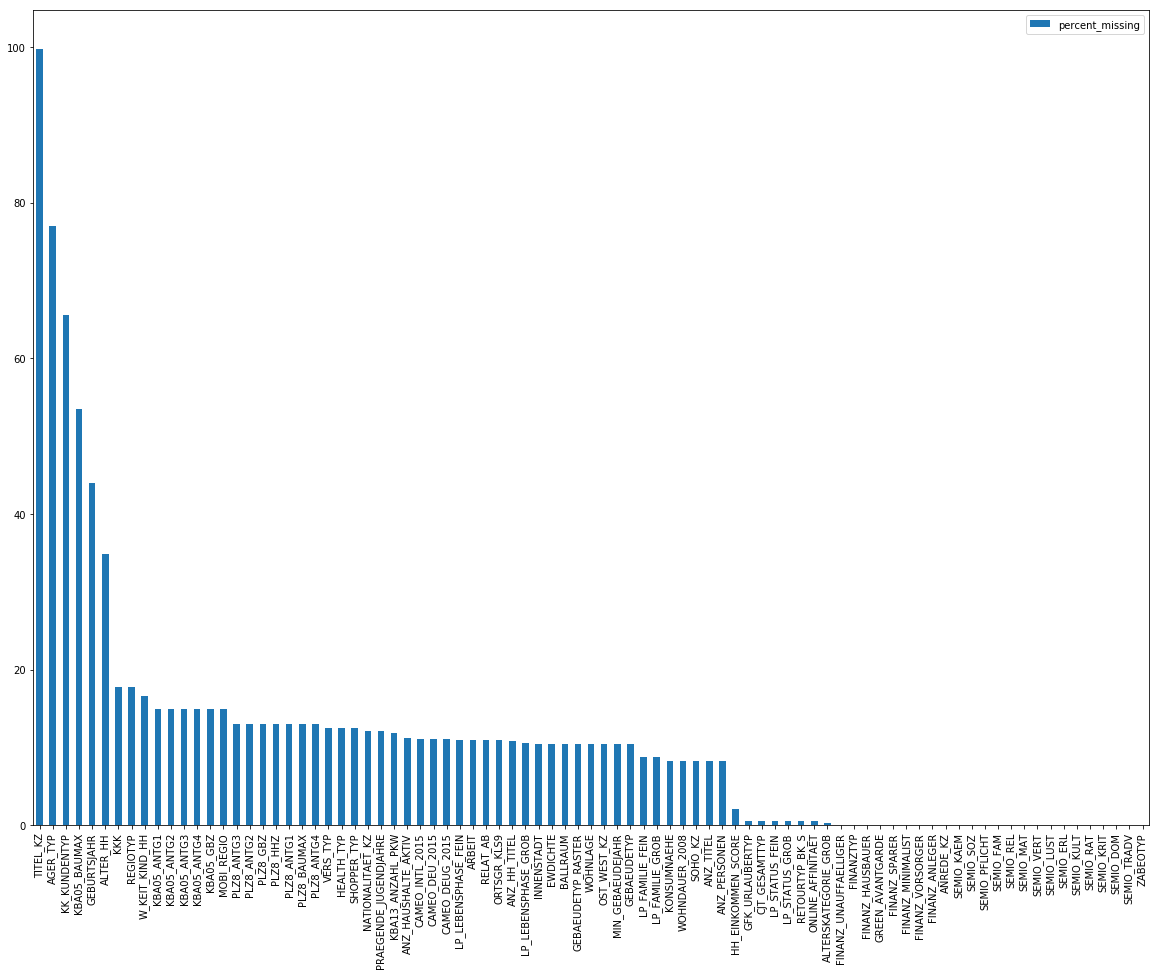

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
percent_missing = azdias.isnull().sum() * 100 / len(azdias)
missing_value_azdias = pd.DataFrame({'column_name': azdias.columns,
                                 'percent_missing': percent_missing}).sort_values(by = 'percent_missing', ascending=0)
missing_value_azdias.plot.bar(figsize = (20,15))

## Assesment: 
The above plot shows 3 columns have 50% or more data missing. The first 6 bars i.e. columns have more than 20% data missing and the remainder of the columns have below 20% missing data. 

In [9]:
count_missing = azdias.isnull().sum()
missing_count_azdias = pd.DataFrame({'column_name': azdias.columns,
                                 'count_missing': count_missing}).sort_values(by = 'count_missing', ascending=0)
missing_count_azdias

,column_name,count_missing
TITEL_KZ,TITEL_KZ,889061
AGER_TYP,AGER_TYP,685843
KK_KUNDENTYP,KK_KUNDENTYP,584612
KBA05_BAUMAX,KBA05_BAUMAX,476524
GEBURTSJAHR,GEBURTSJAHR,392318
ALTER_HH,ALTER_HH,310267
KKK,KKK,158064
REGIOTYP,REGIOTYP,158064
W_KEIT_KIND_HH,W_KEIT_KIND_HH,147988
KBA05_ANTG1,KBA05_ANTG1,133324


In [10]:
# Investigate patterns in the amount of missing data in each column.
percent_missing_filtered25 = missing_value_azdias[percent_missing >= 25]
percent_missing_filtered5 = missing_value_azdias[(missing_value_azdias['percent_missing'] > 5) & (missing_value_azdias['percent_missing'] < 25)]
print('{} columns have 25% or more data missing'.format(len(percent_missing_filtered25)))
print('{} columns have more than 5% and less than 25% data missing'.format(len(percent_missing_filtered5)))

6 columns have 25% or more data missing
47 columns have more than 5% and less than 25% data missing


## Assessment: 
The first 6 columns with more than 25% missing data are good candidates for dropping from the final analysis. Since the high percentage of missing data is likely to be reported as outliers. 

In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
drop_columns = missing_value_azdias.loc[missing_value_azdias['percent_missing'] > 25, 'column_name']
drop_columns.index
azdias.drop(drop_columns, axis='columns', inplace=True)
azdias.info()         

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS_GROB           

#### Discussion 1.1.2: Assess Missing Data in Each Column
 - All the columns with missing data were plotted on a bar plot with values sorted in descending order of percent missing values.
 - Based on this, 6 columns with more than 25% missing values. These were deemed as good candidates for dropping from the final analysis. Since the high percentage of missing data is likely to be reported as outliers.
 - List of dropped columns : 'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR','ALTER_HH'

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [12]:
# How much data is missing in each row of the dataset?
print('The total number of rows in azdias data set is {}'.format(azdias.shape[0]))
print('There are {} rows containing one or more missing value'.format(sum(azdias.isnull().any(axis=1))))
print('Which means {} % rows have missing data'.format(round((sum(azdias.isnull().any(axis=1))/(azdias.shape[0]))*100),3))

The total number of rows in azdias data set is 891221
There are 268012 rows containing one or more missing value
Which means 30 % rows have missing data


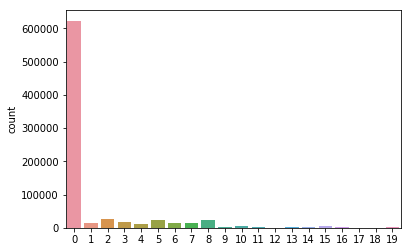

In [13]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
a = azdias.isnull().transpose().sum()
azdias_rows_missing_low = azdias[a<20]
azdias_rows_missing_high = azdias[a>=20]
count_azdias_rows_missing_low = azdias_rows_missing_low.isnull().transpose().sum()
count_azdias_rows_missing_high = azdias_rows_missing_high.isnull().transpose().sum()
sns.countplot(count_azdias_rows_missing_low)

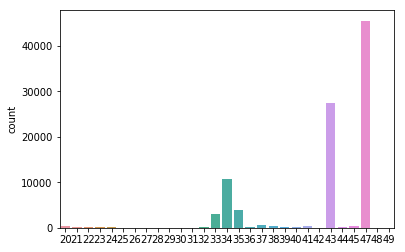

In [14]:
sns.countplot(count_azdias_rows_missing_high)

In [15]:
count_azdias_rows_missing_high.shape

(94144,)

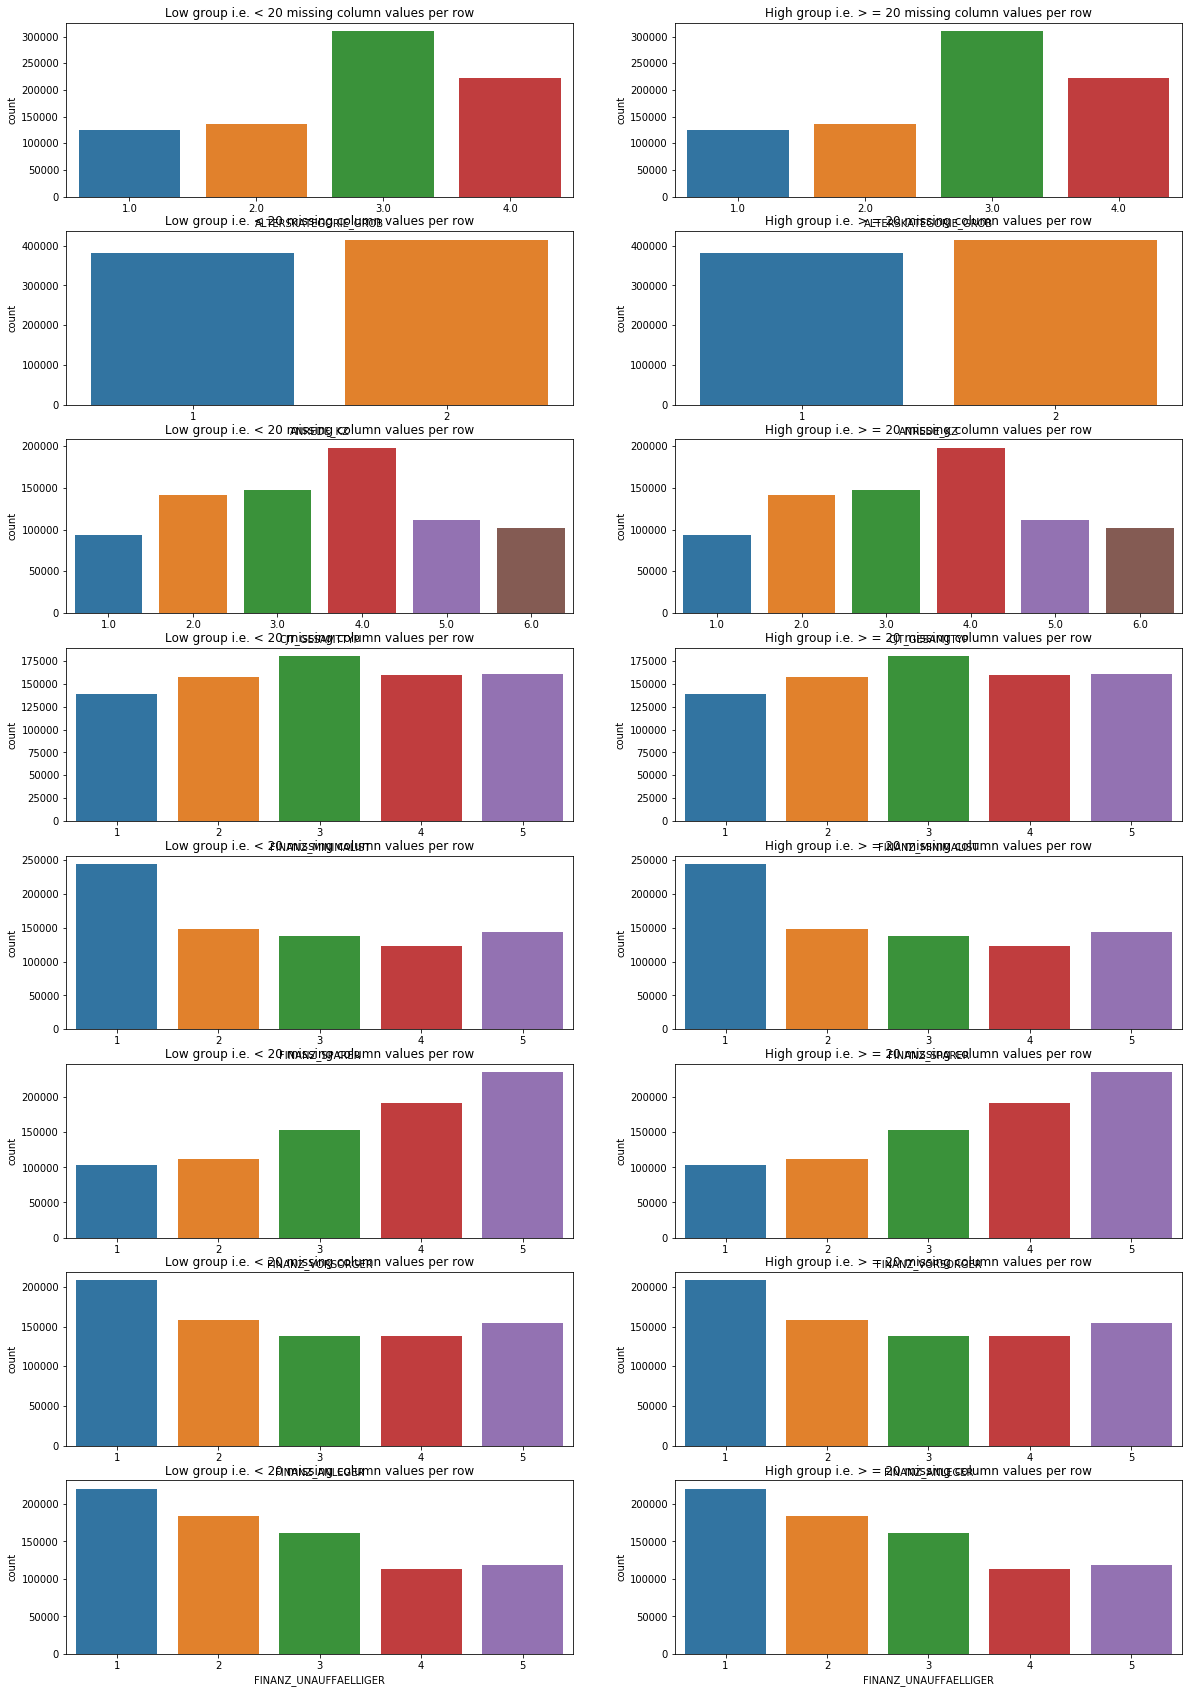

In [16]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20,30))
n = 0
for i in azdias.columns[0:8]:
    sns.countplot(azdias_rows_missing_low.loc[:,i], ax = axes[n,0])
    sns.countplot(azdias_rows_missing_low.loc[:,i], ax = axes[n,1])
    
    axes[n,0].set_title('Low group i.e. < 20 missing column values per row')
    axes[n,1].set_title('High group i.e. > = 20 missing column values per row')

    n = n+1

In [17]:
azdias_rows_missing_low.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [18]:
azdias_rows_missing_low.shape

(797077, 79)

#### Discussion 1.1.3: Assess Missing Data in Each Row
##### Missing Data
- About 30% of the rows (268012 out of the total 891221) have some missing data
##### Handling missing data
- Drop all rows with missing data i.e. drop 30% of the rows
- Drop all the rows with more than 20 missing values i.e. the high group (94, 144 rows out of 891221) which is about 10.5% of the total data
- Impute missing values in the rows with mean (due to least sensitivity to outliers). 

I will proceed for now with excluding all the rows with more than 20 missing values i.e. 10.5% of the data. I will then impute the missing values in the remainder of the data with mode. 


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [19]:
# How many features are there of each data type?
feat_info.groupby('type').count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


In [20]:
# finding all the categorical features using feat_info
#then identifying the binary and the multieleve categorical features

cat = feat_info[feat_info['type'] == 'categorical']['attribute'].values
cat = [x for x in cat if x in azdias.columns] # only the ones that are kept in azdias dataset
cat_binary = [x for x in cat if azdias[x].nunique()==2]
cat_multi = [x for x in cat if azdias[x].nunique()>2]
azdias[cat].nunique()

ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [21]:
# list of binary features
cat_binary

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [22]:
# locating the non numeric binary feature
for a in cat_binary: 
    print (a, azdias_rows_missing_low[a].unique())

ANREDE_KZ [2 1]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [ 1.  0.]
VERS_TYP [  2.   1.  nan]
OST_WEST_KZ ['W' 'O']


In [23]:
# replacing the non numeric binary feature values with binary values in feature OST_WEST_KZ
azdias_rows_missing_low.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True);

In [24]:
#removing the categorical column with 44 features from the analysis
cat_multi.remove('CAMEO_DEU_2015')
azdias_rows_missing_low.drop('CAMEO_DEU_2015', axis=1, inplace=True)

In [25]:
# checking the number of columns after dropping the one in the above step
azdias_rows_missing_low.shape[1]

78

In [26]:
cat_multi

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015']

In [27]:
# for multi level categorical variables, first filter the rows with no nan values
#then loop over each column in the cat_multi variable to first one hot encode th dummy variables, then join the new dummy colmns
#to the original data followed by dropping the original column itself from the azdias_rows_missing_low dataset
for y in cat_multi:
    temp_data = azdias_rows_missing_low[y][azdias_rows_missing_low[y].notnull()]
    ohe_data = pd.get_dummies(temp_data, prefix = y)
    azdias_rows_missing_low =azdias_rows_missing_low.join(ohe_data)
    azdias_rows_missing_low.drop([y], axis = 1, inplace = True)

In [28]:
azdias_rows_missing_low.shape

(797077, 150)

In [29]:
azdias_rows_missing_low.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Columns: 150 entries, ALTERSKATEGORIE_GROB to CAMEO_DEUG_2015_9
dtypes: float64(107), int64(23), object(1), uint8(19)
memory usage: 837.2+ MB


#### Discussion 1.2.1: Re-Encode Categorical Features

- For the binary categorical features: 
    - the feature with non numeric binary values was identified and non numeric values were replaced with numeric values
- For multi level categorical features:
    - The feature with 44 variable values was dropped from the dataset (and the analysis)
    - For remainder of the multi level features, one hot encoding was done to prepare these for analysis. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [30]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_rows_missing_low[['PRAEGENDE_JUGENDJAHRE']].describe()

,PRAEGENDE_JUGENDJAHRE
count,768753.000000
mean,9.279761
std,4.025921
min,1.000000
25%,6.000000
50%,9.000000
75%,14.000000
max,15.000000


In [31]:
# creating movement capturing variable for PRAEGENDE_JUGENDJAHRE
mainstream = [1,3,5,8,10,12,14]  # mainstream values as indicated in Data_Dictionary.md
avantgarde = [2,4,5,7,9,11,13,15]  # avantgarde values as indicated in Data_Dictionary.md

def movement(z):
    if z in mainstream:
        return 1
    if z in avantgarde:
        return 0
    else:
        return z
azdias_rows_missing_low['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_rows_missing_low['PRAEGENDE_JUGENDJAHRE'].apply(movement)

In [32]:
#creating varaible to capture generation by decade
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] 
b = [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90] #VARIABLES a and b contain the index ad the decade value maaped 
                                                                #to the index per Data_Dictionary.md

gen_by_decade = pd.Series(b, index = a)
azdias_rows_missing_low['PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE'] = azdias_rows_missing_low['PRAEGENDE_JUGENDJAHRE'].map(gen_by_decade)

In [33]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_rows_missing_low['CAMEO_INTL_2015'].head()

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [34]:
azdias_rows_missing_low['CAMEO_INTL_2015_wealth'] = azdias_rows_missing_low['CAMEO_INTL_2015'].str[0] # extract tens place digit and put it in the new column
azdias_rows_missing_low['CAMEO_INTL_2015_lifestage'] = azdias_rows_missing_low['CAMEO_INTL_2015'].str[1] # extract ones place digit

In [35]:
azdias_rows_missing_low['CAMEO_INTL_2015_wealth'].head() # checking work

1    5
2    2
3    1
4    4
5    5
Name: CAMEO_INTL_2015_wealth, dtype: object

In [36]:
# Drop remainder of the mixed type columns from data
drop_columns2 = []
for attribute in feat_info[feat_info['type']=='mixed'].attribute:
    drop_columns2.append(attribute)
drop_columns2.remove('KBA05_BAUMAX') # KBA05_BAUMAX was removed previously in section 1.1.2
drop_columns2

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [37]:
azdias_rows_missing_low.drop(drop_columns2, axis='columns', inplace=True)
azdias_rows_missing_low.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Columns: 148 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_lifestage
dtypes: float64(104), int64(23), object(2), uint8(19)
memory usage: 825.0+ MB


In [38]:
drop_columns

TITEL_KZ            TITEL_KZ
AGER_TYP            AGER_TYP
KK_KUNDENTYP    KK_KUNDENTYP
KBA05_BAUMAX    KBA05_BAUMAX
GEBURTSJAHR      GEBURTSJAHR
ALTER_HH            ALTER_HH
Name: column_name, dtype: object

In [39]:
drop_columns2

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

#### Discussion 1.2.2: Engineer Mixed-Type Features

- The data from column  PRAEGENDE_JUGENDJAHRE was divided into two new columns based on the information provided in Data_Dictionary.md:
    1) based on the movement type
    2) based on the generation by decade
- The data from the column CAMEO_INTL_2015 was also divided over two new columns based on the instruction
    1) tens place digit specifies the wealth
    2) ones place digit specifies the lifestage
- The rest of the mixed type columns, along with the original columns( PRAEGENDE_JUGENDJAHRE,CAMEO_INTL_2015) were dropped from the data set for analysis. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [38]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


In [40]:
# Check that columns have the right type
np.unique(azdias_rows_missing_low.dtypes.values)

array([dtype('uint8'), dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [41]:
azdias_rows_missing_low.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Columns: 148 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_lifestage
dtypes: float64(104), int64(23), object(2), uint8(19)
memory usage: 825.0+ MB


In [41]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [42]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ... (1.1)
    for attribute in feat_info['attribute']:
        temp = feat_info[feat_info['attribute']==attribute].missing_or_unknown.iloc[0].replace('[','').replace(']','').split(',')
        nan_list = [float(x) if x.lstrip('-').isnumeric() else x for x in temp]
        #lstrip for getting rid of the negative sign in the string
        #isnumeric checks whether it is number or not
        df[attribute].replace(to_replace=nan_list,
                      value=np.nan, inplace=True)
    # remove selected columns 
    df.drop(drop_columns, axis='columns', inplace=True)
    #and rows, ...
    df_n_miss = df.isnull().transpose().sum()
    df_rows_missing_low = df[df_n_miss<20]
    # select, re-encode, (1.2.1)
    #all categorical columns split to binary and multi
    cat = feat_info[feat_info['type'] == 'categorical']['attribute'].values
    cat = [x for x in cat if x in  df_rows_missing_low.columns] # only the ones that are kept in azdias dataset
    cat_binary = [x for x in cat if  df_rows_missing_low[x].nunique()==2]
    cat_multi = [x for x in cat if df_rows_missing_low[x].nunique()>2]
    # binary non numeric categorical column converted to numeric
    df_rows_missing_low.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True);
    #drop CAMEO_DEU_2015 due to too many features(44)
    cat_multi.remove('CAMEO_DEU_2015')
    df_rows_missing_low.drop('CAMEO_DEU_2015', axis=1, inplace=True)
    # One hot encode the remainder of the multi level categorical columns
    for y in cat_multi:
        temp_data = df_rows_missing_low[y][df_rows_missing_low[y].notnull()]
        ohe_data = pd.get_dummies(temp_data, prefix = y)
        df_rows_missing_low =df_rows_missing_low.join(ohe_data)
        df_rows_missing_low.drop([y], axis = 1, inplace = True)

    #and engineer column values (1.2.2)
    #engineer PRAEGENDE_JUGENDJAHRE
    #movement 
    mainstream = [1,3,5,8,10,12,14]  # mainstream values as indicated in Data_Dictionary.md
    avantgarde = [2,4,5,7,9,11,13,15]  # avantgarde values as indicated in Data_Dictionary.md
    df_rows_missing_low['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_rows_missing_low['PRAEGENDE_JUGENDJAHRE'].apply(movement)
    #generation by decade
    a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] 
    b = [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90] #VARIABLES a and b contain the index ad the decade value maaped 
                                                              #to the index per Data_Dictionary.md
    gen_by_decade = pd.Series(b, index = a)
    df_rows_missing_low['PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE'] = df_rows_missing_low['PRAEGENDE_JUGENDJAHRE'].map(gen_by_decade)

    #engineer CAMEO_INTL_2015
    #wealth
    df_rows_missing_low['CAMEO_INTL_2015_wealth'] = df_rows_missing_low['CAMEO_INTL_2015'].str[0] # extract tens place digit and put it in the new column
    #lifestage
    df_rows_missing_low['CAMEO_INTL_2015_lifestage'] = df_rows_missing_low['CAMEO_INTL_2015'].str[1] # extract ones place digit

    # Drop remainder of the mixed type columns from data
    drop_columns2 = []
    for attribute in feat_info[feat_info['type']=='mixed'].attribute:
        drop_columns2.append(attribute)
    drop_columns2.remove('KBA05_BAUMAX') # KBA05_BAUMAX was removed previously in section 1.1.2
    df_rows_missing_low.drop(drop_columns2, axis='columns', inplace=True)

    # Add columns filled with zero for column wih no data
    columns = [col for col in azdias_rows_missing_low if col not in df_rows_missing_low]
    for column in columns:
        df_rows_missing_low[column] = 0

    
    #Return the cleaned dataframe.
    return df_rows_missing_low


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [43]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputer = Imputer()
azdias_rows_missing_low = pd.DataFrame(imputer.fit_transform(azdias_rows_missing_low), columns = azdias_rows_missing_low.columns)

In [44]:
azdias_rows_missing_low.isnull().values.any()

False

In [45]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_rows__missing_low = pd.DataFrame(scaler.fit_transform(azdias_rows_missing_low), columns = azdias_rows_missing_low.columns)


In [46]:
azdias_rows__missing_low.shape

(797077, 148)

### Discussion 2.1: Apply Feature Scaling

In this step the following were performed:
1) Used Imputer package from sklearn to impute the missing values in the data set (remember, we only retained the rowswith less than 20 missing column values previously) with column mean. 
2) Used standard scaler package in sklearn to scale the features.     

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [47]:
# Apply PCA to the data.
pca = PCA()
general_data_pca = pca.fit_transform(azdias_rows__missing_low)

In [48]:
def scree_plot(pca, percent_var):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    ax.axhline(percent_var, linestyle='dashed', color='black')
    ax.xaxis.grid()
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

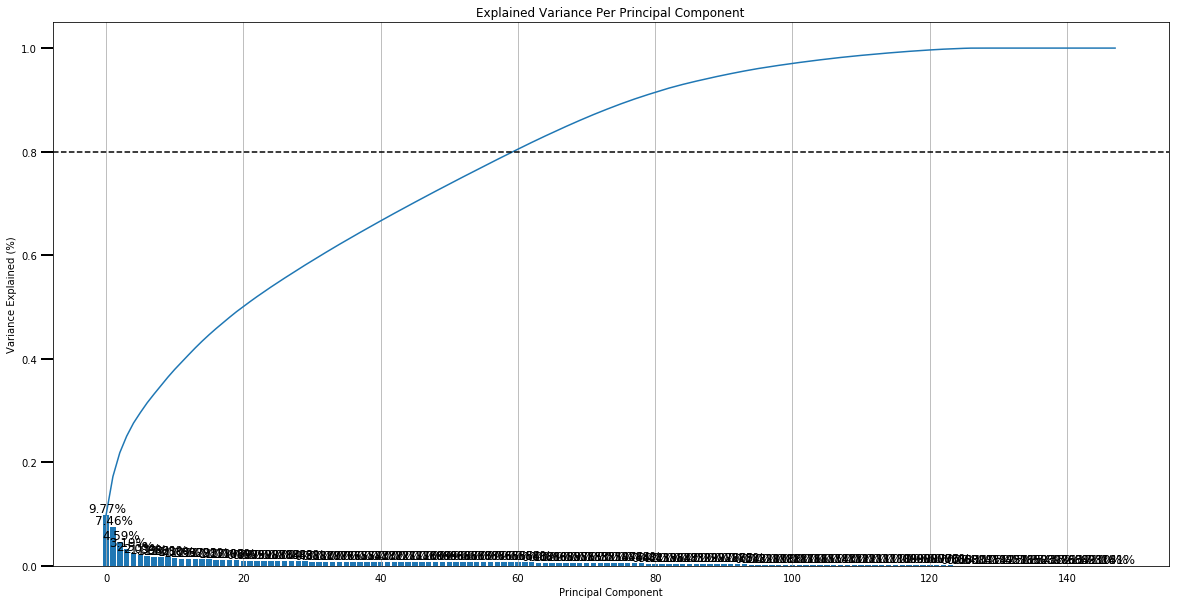

In [49]:
# Investigate the variance accounted for by each principal component.
v = scree_plot(pca, 0.8)


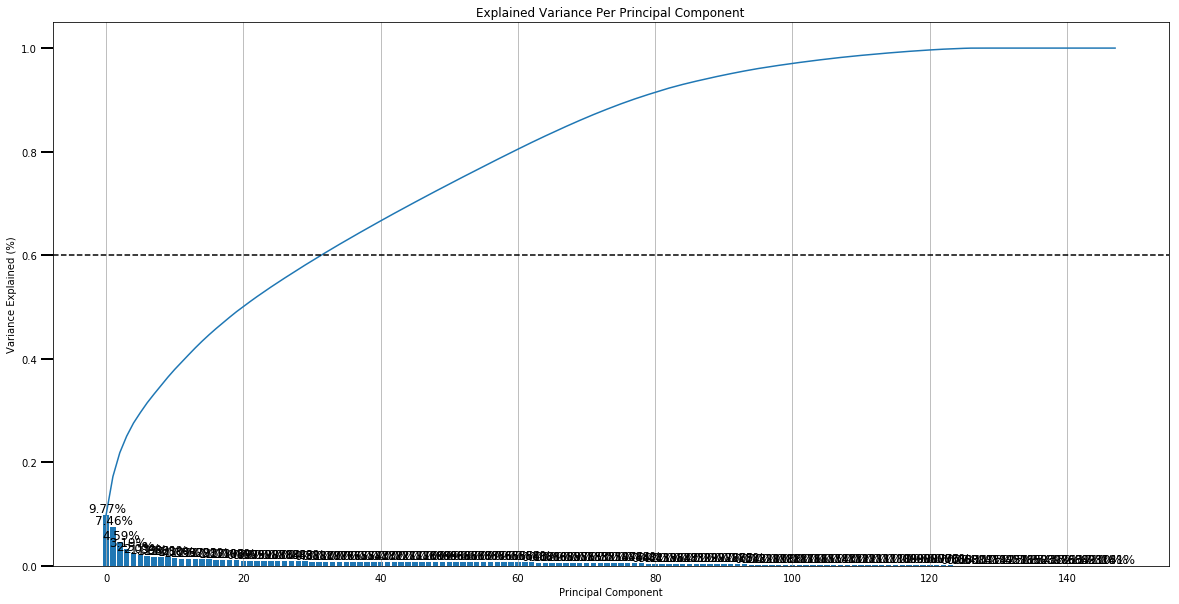

In [50]:
v = scree_plot(pca, 0.6)

In [51]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(40)
general_data_pca = pca.fit_transform(azdias_rows__missing_low)

In [52]:
pca.explained_variance_ratio_.sum()

0.65371926493395782

### Discussion 2.2: Perform Dimensionality Reduction

In this step PCA was applied to all the components, and a scree plot (using the provided helper functions) was added to assess the principal components amounting to 80% and 60% variance in the data. 
Then, pca was performed again, retaining 40 features - which explain a little over 60% of the totla variance in the data set. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [53]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def weight_mapper(df, pca, n_princ_component):
    pca_component = pd.DataFrame(np.round(pca.components_, 4), columns = df.keys()).iloc[n_princ_component-1]
    pca_component.sort_values(ascending=False, inplace=True)
    pca_component = pd.concat([pca_component.head(8), pca_component.tail(8)])
    
    
    pca_component.plot(kind='bar', title='Principal component ' + str(n_princ_component))
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()

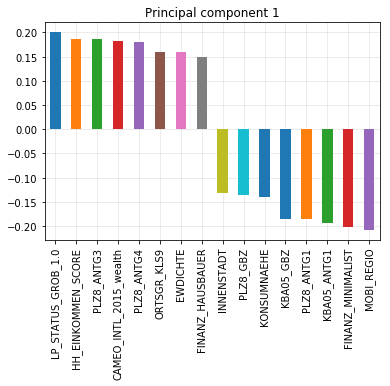

In [54]:
weight_mapper(azdias_rows__missing_low, pca, 1)

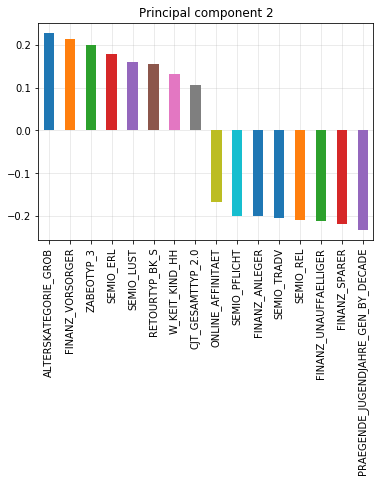

In [55]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight_mapper(azdias_rows__missing_low, pca, 2)

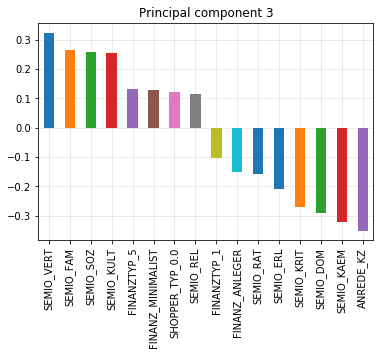

In [56]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight_mapper(azdias_rows__missing_low, pca, 3)


### Discussion 2.3: Interpret Principal Components

#### First Principal Component
Positive associations: 
LP_STATUS_GROB_1: low-income earners
HH_EINKOMMEN_SCORE: Estimated household income (lower income groups have higher score)
PLZ8_ANTG3: # of 6-10 family houses in PLZ8 region

Negative associations:
MOBI_REGIO: Movement pattern (higher score means less movement)
FINANZ_MINIMALIST: Financial tYpology(higher score means lower financial interest)
KBA05_ANTG1: number of 1-2 family houses in microcell

#### Second Principal Component
Positive associations: 
ALTERSKATEGORIE_GROB: Estimated age (older individuals score higher)
FINANZ_VORSORGER: Financial typology, be prepared (higher score means lower financial interest)
ZABEOTYP_3: Energy consumption, fair supplied (binary)

Negative associations:
PRAEGENDE_JUGENDJAHRE_decade: Decade of movement of person's youth (highest is 90s)
FINANZ_SPARER: Financial typology, MONEY-SPARER (higher score means lower financial interest)
FINANZ_UNAUFFAELLIGER: Financial typology, inconspicuous (higher score is lower interest))

#### Third Principal Component
Positive associations: 
SEMIO_VERT: Personality typology - dreamful (higher score shows lower affinity)
SEMIO_FAM: Personality typology - family-minded (higher score shows lower affinity)
SEMIO_SOZ: Personality typology - socially-minded (higher score shows lower affinity)

Negative associations:
ANREDE_KZ: Gender
SEMIO_KAEM: Personality typology - combative attitude (higher score shows lower affinity)
SEMIO_DOM: Personality typology - dominant-minded (higher score shows lower affinity)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [56]:
pca_features_sample = general_data_pca[np.random.choice(general_data_pca.shape[0], \
                                                    int(general_data_pca.shape[0]*0.2), replace=False)]

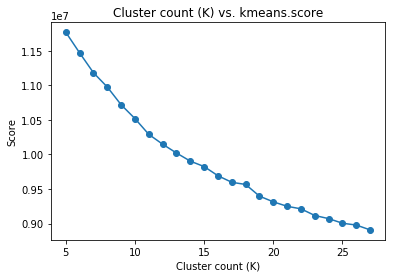

In [57]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

km_score = []
k_range = np.arange(5, 28)

for k in k_range:
    kmeans = KMeans(k).fit(pca_features_sample)
    km_score.append(np.abs(kmeans.score(pca_features_sample)))
    
plt.plot(k_range, km_score, linestyle='-', marker='o');
plt.xlabel('Cluster count (K)');
plt.ylabel('Score');
plt.title('Cluster count (K) vs. kmeans.score');


In [59]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



In [58]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(25).fit(general_data_pca)
kmeans_pop = kmeans.predict(general_data_pca)


In [ ]:
kmeans_pop

### Discussion 3.1: Apply Clustering to General Population
used as a reasonable choice for 
General population data was subsectioned to retain only 20% for faster computing, then clustring performance was evaluatd using the scree plot function provided in helper functions for visualizing the number of clusters that give the best (lowest) score. CLusters count in the range 5-28 was evaluated, and elbow was not observed. Since the project instructions recommned keeping the total number of clusters below 30, I decided to use 25 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [59]:
# Load in the customer demographics data.
customer_data = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [60]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customer_data_clean = clean_data(customer_data)
customer_data_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 141590 entries, 0 to 191651
Columns: 148 entries, ALTERSKATEGORIE_GROB to GEBAEUDETYP_5.0
dtypes: float64(104), int64(24), object(2), uint8(18)
memory usage: 148.9+ MB


In [61]:
#imputing step
customer_data_clean = pd.DataFrame(imputer.transform(customer_data_clean), columns = customer_data_clean.columns)

In [62]:
# scaling std. scaler step
customer_data_clean  = pd.DataFrame(scaler.transform(customer_data_clean ), columns = customer_data_clean.columns)

In [63]:
customer_data_clean.shape

(141590, 148)

In [64]:
customer_data_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage,GEBAEUDETYP_5.0
0,1.184971,-1.043709,1.409202,-1.155407,1.138052,-1.250019,-0.469499,-0.792444,1.884467,-1.625745,...,-0.390058,-0.274916,-0.394382,-0.331663,-0.454017,-0.399356,49.242874,-5.052960,-0.179980,-1.941924
1,1.184971,0.958121,1.409202,-1.155407,1.138052,-1.250019,0.959974,0.628207,1.884467,-0.270203,...,2.582735,-0.274916,-0.394382,-0.331663,-0.454017,-0.399356,49.242874,-4.913219,0.505358,-1.941924
2,1.184971,-1.043709,1.409202,-1.155407,1.138052,-0.570914,-1.184235,-0.792444,-0.530654,-0.270203,...,-0.390058,-0.274916,-0.394382,-0.331663,-0.454017,2.522600,39.198971,-4.983090,0.505358,-1.941924
3,0.201448,-1.043709,-0.042631,-1.155407,0.411813,0.787296,1.674710,-0.792444,-0.530654,1.085338,...,-0.390058,-0.274916,2.554416,-0.331663,-0.454017,2.522600,69.330678,-4.843349,-1.550656,-1.941924
4,0.201448,-1.043709,1.409202,-1.155407,1.138052,-1.250019,-0.469499,-0.082119,1.884467,1.085338,...,2.582735,-0.274916,-0.394382,-0.331663,-0.454017,-0.399356,49.242874,-4.913219,0.505358,-1.941924


In [65]:
#pca transform
customer_pca = pca.transform(customer_data_clean)

In [66]:
#clustering
kmeans_customer = kmeans.predict(customer_pca)

In [67]:
kmeans_customer

array([12,  6, 15, ..., 12,  8, 17], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

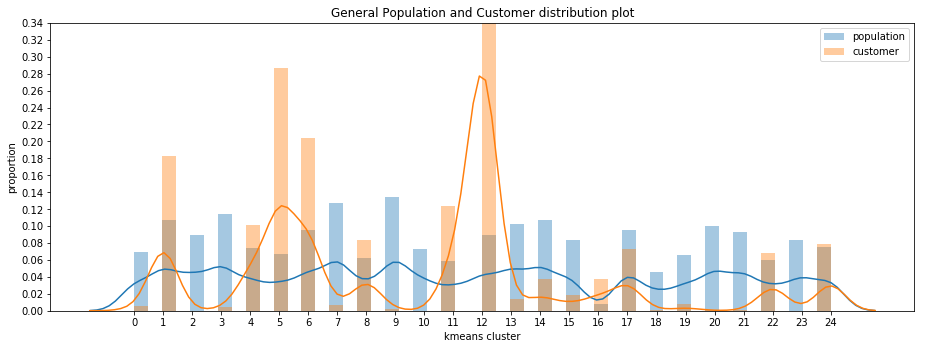

In [68]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig = plt.figure()
ax = fig.add_axes([0,0,2,1], title = 'General Population and Customer distribution plot')
sns.distplot(kmeans_pop, label = 'population', ax = ax)
sns.distplot(kmeans_customer, label = 'customer', ax = ax)
plt.xticks(np.arange(0,25,1))
plt.yticks (np.arange(0,0.35,0.02))
plt.xlabel('kmeans cluster')
plt.ylabel('proportion')
ax.legend();

Text(0.5,1,'Customer kmeans countplot')

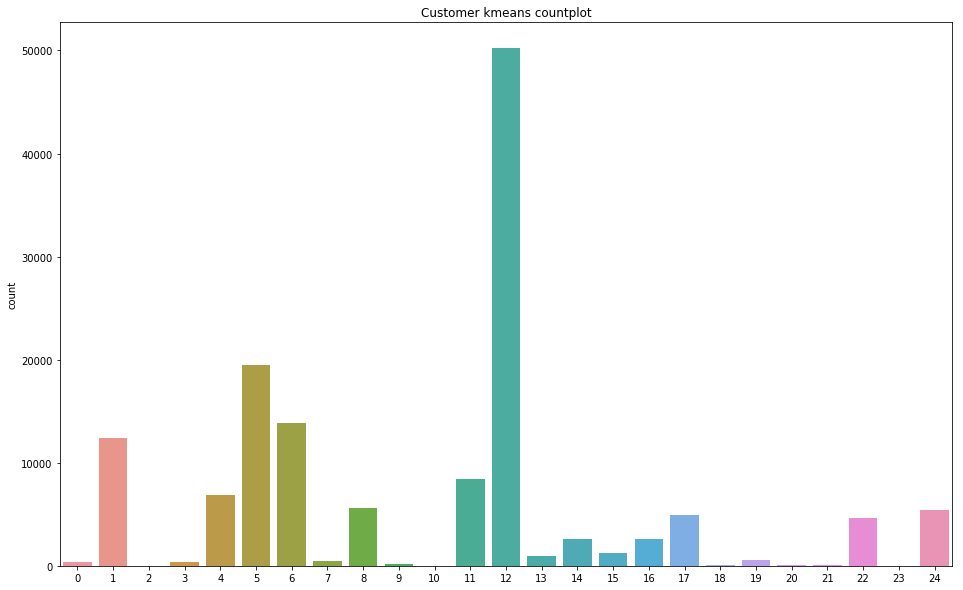

In [69]:
# customer data kmeans count plot
plt.figure(figsize=(16,10))
sns.countplot(kmeans_customer)
plt.title('Customer kmeans countplot')

Text(0.5,1,'Popuation kmeans countplot')

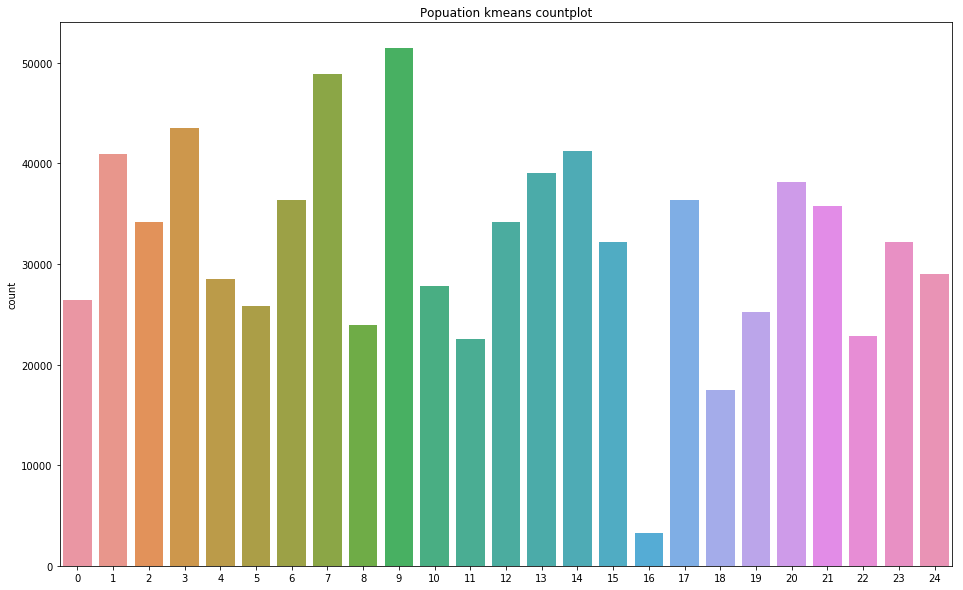

In [70]:
# general population data kmeans count plot
plt.figure(figsize=(16,10))
sns.countplot(kmeans_pop)
plt.title('Popuation kmeans countplot')

In [71]:
cust_df = pd.DataFrame(kmeans_customer,columns=['Cluster']).reset_index().groupby('Cluster').count()/len(kmeans_customer)*100
pop_df = pd.DataFrame(kmeans_pop,columns=['Cluster']).reset_index().groupby('Cluster').count()/len(kmeans_pop)*100
diff = (cust_df-pop_df)
diff.rename_axis({'index':'DiffPerc'}, axis=1, inplace=True)
cust_df.rename_axis({'index':'CustPerc'}, axis=1, inplace=True)
pop_df.rename_axis({'index':'PopPerc'}, axis=1, inplace=True)
diff = diff.join(cust_df).join(pop_df).sort_values('DiffPerc',ascending=False)
diff.fillna(0, inplace=True)
diff

,DiffPerc,CustPerc,PopPerc
Cluster,,,
12,31.189430,35.474963,4.285533
5,10.500990,13.735433,3.234443
6,5.262171,9.819196,4.557025
1,3.646449,8.785225,5.138776
11,3.136414,5.962992,2.826578
16,1.410483,1.817219,0.406736
4,1.310151,4.881701,3.571550
8,0.992065,3.990395,2.998330
22,0.429524,3.298256,2.868732


In [73]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_specs = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_)), columns=azdias_rows__missing_low.columns)
cluster_specs

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
0,2.321369,1.721668,2.432695,3.570639,2.762696,3.847186,3.311412,2.936063,0.184588,2.236171,...,0.153578,0.099367,0.128372,0.091656,0.140787,0.124805,0.908829,84.022810,3.180549,2.829334
1,3.982127,1.917544,2.595821,1.440669,4.695895,1.765581,1.386264,4.581539,-0.012025,1.797127,...,-0.010073,-0.017541,0.201351,0.159530,0.373254,0.206091,1.185971,57.622466,4.375900,2.824969
2,2.618262,1.517973,3.732440,3.042753,3.040806,3.364051,3.197570,1.624937,0.392855,2.270666,...,0.244622,0.096887,0.088307,0.035321,0.061363,0.036015,0.619252,81.857815,2.370135,3.135180
3,1.803819,1.983548,1.121369,4.564144,2.231903,4.598864,4.103308,4.158754,0.026084,2.228434,...,0.130808,0.054289,0.190841,0.106314,0.184589,0.146370,1.008154,86.639050,3.516554,2.791191
4,2.932194,1.421813,3.852642,2.263305,3.602871,2.619539,2.437503,2.482112,0.392549,2.186873,...,0.216103,0.057333,0.156191,0.113816,0.042364,0.025322,1.108066,71.374581,2.554010,3.187994
5,3.701736,1.890294,4.328326,1.312955,4.483863,2.339366,1.740863,2.602555,-0.019280,1.979540,...,0.238835,0.076479,0.139211,0.099826,0.045461,0.009623,1.264492,60.642029,2.520286,3.372966
6,3.563798,1.941281,4.395337,1.322742,4.477865,1.863410,1.907809,2.479680,0.942719,2.062662,...,0.177952,0.067201,0.088395,0.015315,0.042270,0.027117,1.204238,62.143977,2.004532,3.667052
7,1.704776,1.993556,1.015327,4.481225,2.109841,4.293491,3.770936,4.466163,0.037514,2.171826,...,0.004508,0.066462,0.069290,0.135098,0.340078,0.397917,0.996525,85.915784,4.597186,1.777342
8,3.505660,1.937865,3.067243,1.473876,4.571395,1.623246,1.955072,4.180806,0.378937,2.152208,...,0.125888,0.142901,0.195722,0.144215,0.139460,0.053473,1.135275,62.159007,3.247210,3.264528
9,1.844267,0.957318,1.723243,4.596814,1.899091,3.754814,3.979492,3.717228,0.067717,2.335150,...,0.030910,0.043743,0.097619,0.127726,0.309218,0.349655,0.907991,88.135335,4.395626,2.003851


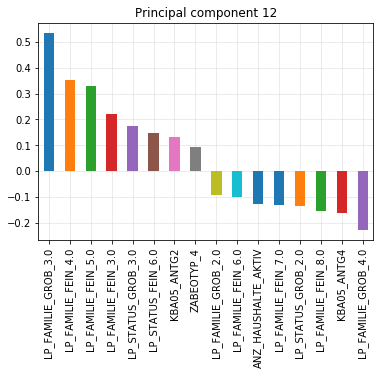

In [75]:
weight_mapper(azdias_rows__missing_low, pca, 12) #checking if cluster 14 maps to same features for both customer and general population

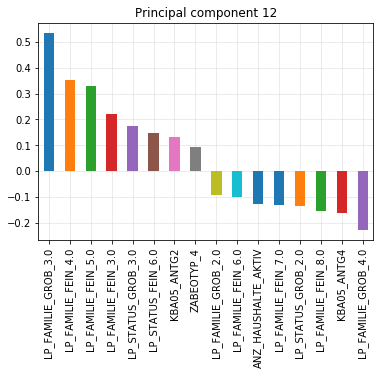

In [76]:
#mapping most overrepresented customer clsuter to top 10/bottom 10 features
weight_mapper(customer_data_clean, pca, 12)

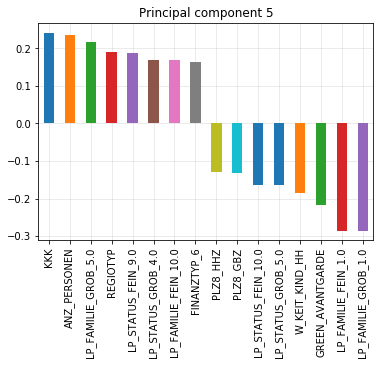

In [77]:
weight_mapper(customer_data_clean, pca, 5)

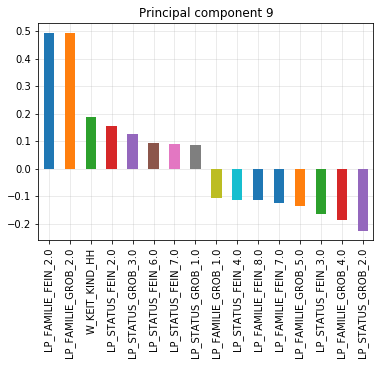

In [78]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
#mapping most underrepresented customer clsuter to top 10/bottom 10 features
weight_mapper(customer_data_clean, pca, 9)

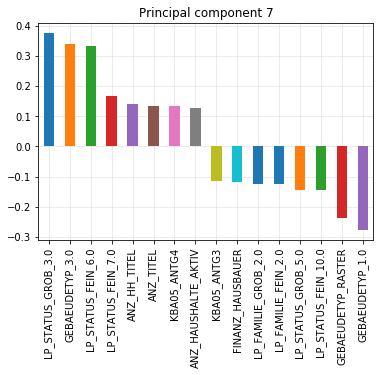

In [79]:
weight_mapper(customer_data_clean, pca, 7)

### Discussion 3.3: Compare Customer Data to Demographics Data

#### Popular customer segment

- The distribution overlay plot of the customer and general population data shows that clusters 12, 5 amd 6 in descending order are most over represented in the customers. This is indicated by large positive differences in the proportion of customer minus general population as shown in the difference table. 

    - Cluster 12 is comprised of individuals who are single parents with teenage or older kids, independent workers and reside in 3-5 family houses in micorcell 
    - Cluster 5 is positively correlated to purchaising power, bigger family size and inconspicous financial status. People in this cluster are houseowners.

#### Unpoplar customer segment
- The most underrepresented groups in the customers are the people belonging to clusters 9,7 and 3 as shown in the distribution plot and represented by high negative difference in the proportions (customer - population).

    - Cluster 9 is comprised of individuals who are couples, mostly low income earners and some average to mid income earners.
    - Cluster 7 is comprised of individuals who are independent workers. 
    


This analysis indicates that the primary customers of this business are financially well off individuals who are well settled in their personal and business lives, whereas the underrepresented groups comprises primarily of the lower middle class.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.